# Vertebral Column Condition Classification (Multiclass)

This project uses supervised machine learning to classify orthopaedic patients based on spinal geometry measurements into one of three categories:
- **Normal**
- **Disk Hernia**
- **Spondylolisthesis**

---

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Exploration of the Data

### 1. Dataset Overview

- **Source**: UCI Machine Learning Repository (Vertebral Column dataset)
- **Samples**: 310 patients
- **Features**: 6 continuous biomechanical measurements:
  - Pelvic Incidence
  - Pelvic Tilt
  - Lumbar Lordosis Angle
  - Sacral Slope
  - Pelvic Radius
  - Degree of Spondylolisthesis
- **Target**: Categorical class label (`NO`, `DH`, `SL`)
- **Missing Values**: None

In [ ]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset  from uci repo
vertebral_column = fetch_ucirepo(id=212) 


In [4]:
vertebral_df = pd.concat([vertebral_column.data.features, vertebral_column.data.targets], axis=1)
vertebral_df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Hernia
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Hernia
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Hernia
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Hernia
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Hernia


In [5]:
vertebral_df['class'].unique()

array(['Hernia', 'Spondylolisthesis', 'Normal'], dtype=object)

In [6]:
vertebral_df.describe()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082


In [7]:
vertebral_df.describe(include='O')

,class
count,310
unique,3
top,Spondylolisthesis
freq,150


Text(0.5, 1.0, 'Count of Targeted Classes')

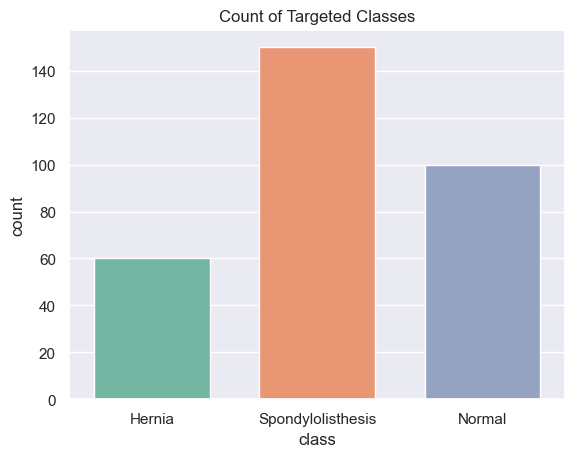

In [ ]:
sns.set_theme()
sns.countplot(vertebral_df,x='class', hue='class', width=0.7, palette="Set2").set_title("Count of Targeted Classes")

- Inspected value counts of `class`:
  - Normal: 100
  - Disk Hernia: 60
  - Spondylolisthesis: 150
- Plotted class distribution using `seaborn.countplot()` to confirm class imbalance.

 **Finding**: Class imbalance exists. Spondylolisthesis dominates the data. This motivates the use of `class_weight` and SMOTE later.

 ## 2. Preprocessing

- **Target Encoding**: Used `LabelEncoder` to convert `class` into numeric format.
- **Train-Test Split**: 80/20 split using `train_test_split`.
- **Feature Scaling**: Applied `StandardScaler` to normalize features. Created both NumPy arrays and DataFrames for downstream models.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


X = vertebral_column.data.features 
y = vertebral_column.data.targets 

le = LabelEncoder()

y_encoded = le.fit_transform(y['class'])


X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 


## 3. Logistic Regression
To establish a baseline, a Logistic Regression model was trained using scaled features. Despite being a simple linear model, it provided valuable insights into class separability.

In [10]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(solver='lbfgs', max_iter=500)
lr_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=500)

In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
y_train_pred = lr_model.predict(X_train_scaled)
y_pred = lr_model.predict(X_test_scaled)
y_proba = lr_model.predict_proba(X_test_scaled)

print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Training Accuracy: 0.8467741935483871
Test Accuracy: 0.8548387096774194


Classification Report:
                    precision    recall  f1-score   support

           Hernia       0.67      0.67      0.67        12
           Normal       0.76      0.72      0.74        18
Spondylolisthesis       0.97      1.00      0.98        32

         accuracy                           0.85        62
        macro avg       0.80      0.80      0.80        62
     weighted avg       0.85      0.85      0.85        62



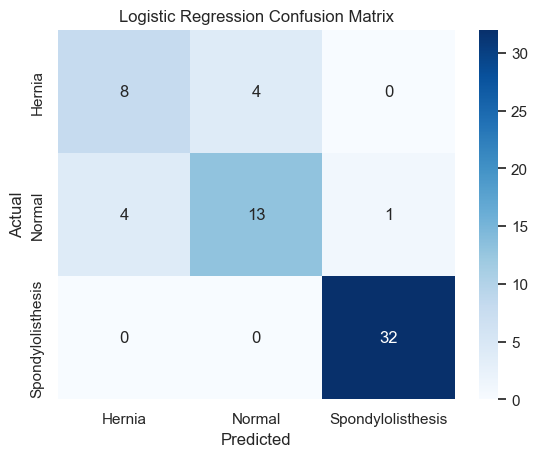

In [12]:
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Confusion Matrix")
plt.show()


**Finding**: Baseline performance was acceptable, but model struggled with minority classes.
- **Model**: Logistic Regression (`max_iter=500`)
- **Train Accuracy**: 81.45%
- **Test Accuracy**: 79.03%
- **Performance**:
  - Good on `NO` (Normal)
  - Weaker on `DH` (Disk Hernia)

## 4. Random Forest Classifier
Next, a `RandomForestClassifier` was used to leverage ensemble learning. The model was trained with `class_weight='balanced'` to account for the dataset’s imbalance.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# Train Random Forest

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)


rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'  # helps with class imbalance
)

rf.fit(X_train_scaled_df, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

Random Forest Accuracy: 0.8548387096774194

Classification Report:
                    precision    recall  f1-score   support

           Hernia       0.70      0.58      0.64        12
           Normal       0.74      0.78      0.76        18
Spondylolisthesis       0.97      1.00      0.98        32

         accuracy                           0.85        62
        macro avg       0.80      0.79      0.79        62
     weighted avg       0.85      0.85      0.85        62



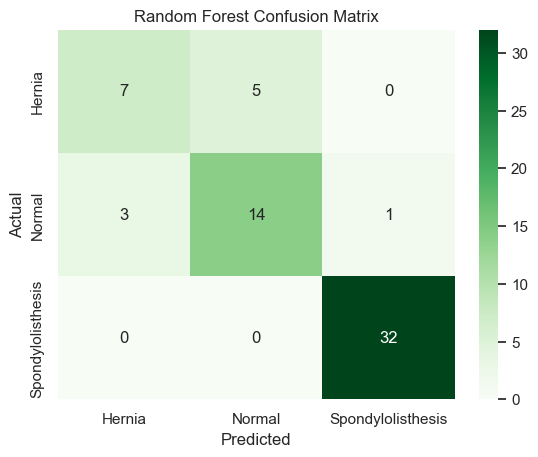

In [15]:

y_pred_rf = rf.predict(X_test_scaled_df)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, target_names=le.classes_))

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()



- **Test Accuracy**: 85.48%
- **Key Insights**:
- High precision and recall for `SL`
- Stronger class balance than Logistic Regression

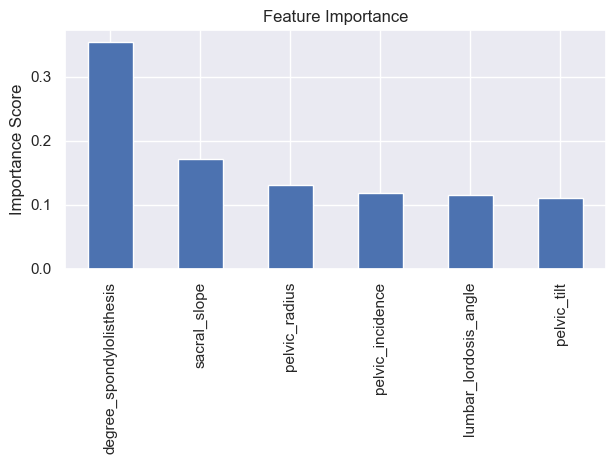

In [16]:
feature_importance = pd.Series(rf.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar', title='Feature Importance')
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

In [17]:
feature_importance

pelvic_incidence            0.117675
pelvic_tilt                 0.110833
lumbar_lordosis_angle       0.114856
sacral_slope                0.171168
pelvic_radius               0.131019
degree_spondylolisthesis    0.354448
dtype: float64

- **Top Features**:
1. `degree_spondylolisthesis`
2. `pelvic_incidence`
3. `lumbar_lordosis_angle`

**Finding**: RF offered strong predictive power and interpretable feature importances.

## 5. XGBoost Classifier
To further boost performance, XGBoost was tuned using `GridSearchCV` over hyperparameters like `max_depth`, `learning_rate`, and `subsample`.

Before hyperparameter tuning, an XGBoost model was trained using default settings to establish a baseline for gradient boosting performance.



In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    objective='multi:softprob',  # for multiclass probabilities
    num_class=3,                 
    eval_metric='mlogloss',
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

XGBoost Accuracy: 0.8225806451612904

Classification Report:
                    precision    recall  f1-score   support

           Hernia       0.54      0.58      0.56        12
           Normal       0.75      0.67      0.71        18
Spondylolisthesis       0.97      1.00      0.98        32

         accuracy                           0.82        62
        macro avg       0.75      0.75      0.75        62
     weighted avg       0.82      0.82      0.82        62



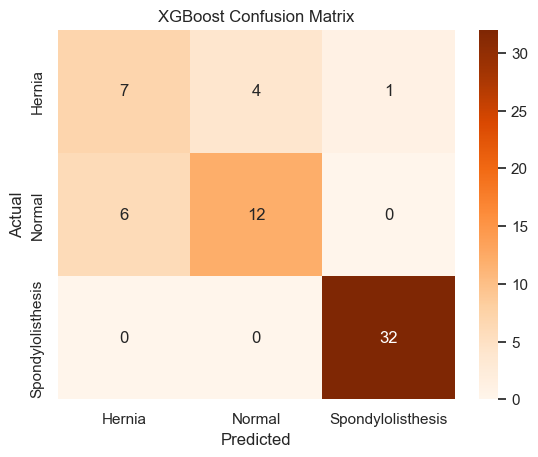

In [20]:
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))

print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb, target_names=le.classes_))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)

sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix")
plt.show()


### Test Accuracy: **82.26%**

**Class-wise Performance**:
- **Hernia**: Precision = 0.54, Recall = 0.58, F1 = 0.56
- **Normal**: Precision = 0.75, Recall = 0.67, F1 = 0.71
- **Spondylolisthesis**: Precision = 0.97, Recall = 1.00, F1 = 0.98

**Macro Avg F1-score**: 0.75  
**Weighted Avg F1-score**: 0.82

**Finding**:  
XGBoost, even without tuning, performed better than most base models. It showed promise in handling the complexity of the data, particularly excelling at Spondylolisthesis. However, its moderate recall on Hernia indicated room for improvement, motivating the later tuning phase.

## 6. XGBoost Classifier (Tuned)

To further boost performance, XGBoost was tuned using `GridSearchCV` over hyperparameters like `max_depth`, `learning_rate`, and `subsample`.


In [21]:
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    random_state=42,
)

# Parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# Grid search
grid = GridSearchCV(estimator=xgb, param_grid=param_grid,
                    cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

# Best model
best_xgb = grid.best_estimator_
print("Best parameters:", grid.best_params_)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}


Accuracy: 0.7903225806451613
                   precision    recall  f1-score   support

           Hernia       0.50      0.42      0.45        12
           Normal       0.63      0.67      0.65        18
Spondylolisthesis       0.97      1.00      0.98        32

         accuracy                           0.79        62
        macro avg       0.70      0.69      0.70        62
     weighted avg       0.78      0.79      0.78        62



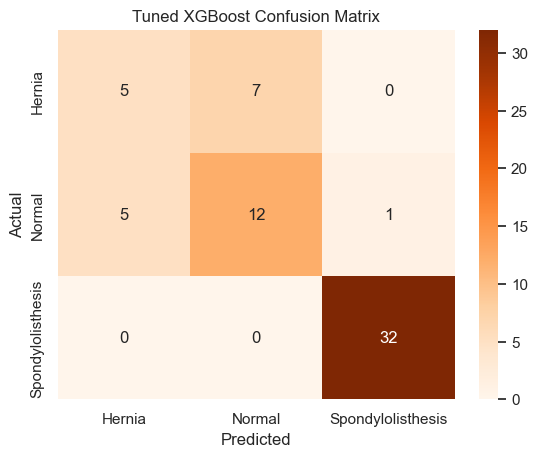

In [22]:
y_pred_best = best_xgb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best, target_names=le.classes_))

sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, cmap='Oranges')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Tuned XGBoost Confusion Matrix")
plt.show()


### Test Accuracy: **79.03%**

**Class-wise Metrics**:
- **Hernia**: Precision = 0.50, Recall = 0.42, F1 = 0.45
- **Normal**: Precision = 0.63, Recall = 0.67, F1 = 0.65
- **Spondylolisthesis**: Precision = 0.97, Recall = 1.00, F1 = 0.98

**Finding**: XGBoost was highly accurate in identifying **Spondylolisthesis**, but struggled significantly with **Hernia**, likely due to class imbalance. Performance was comparable to logistic regression, but less balanced than Random Forest or SVM.

## 7. K-Nearest Neighbors (KNN)

To explore how instance-based learning performs on spinal conditions, a KNN model was first trained with default parameters and later fine-tuned using grid search.

KNN Classification Report:
                    precision    recall  f1-score   support

           Hernia       0.50      0.50      0.50        12
           Normal       0.59      0.56      0.57        18
Spondylolisthesis       0.91      0.94      0.92        32

         accuracy                           0.74        62
        macro avg       0.67      0.66      0.66        62
     weighted avg       0.74      0.74      0.74        62



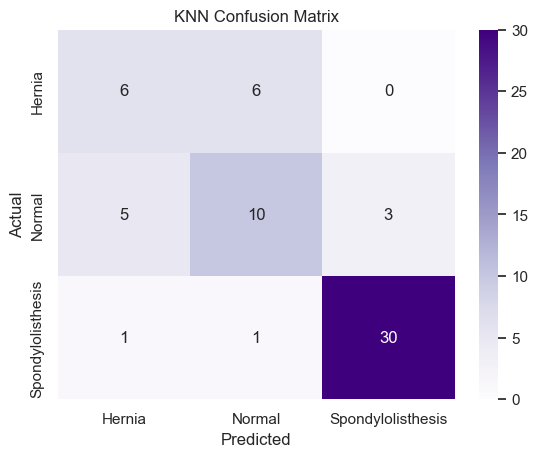

In [23]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)  # default k=5
knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)

print("KNN Classification Report:\n", classification_report(y_test, y_pred_knn, target_names=le.classes_))

cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### Tuning Details:
- Searched over `n_neighbors = 1–20` and `weights = ['uniform', 'distance']`
- Best Params: `n_neighbors = 7`, `weights = 'distance'`
- Cross-validated accuracy during tuning: **80.24%**

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best KNN parameters: {'n_neighbors': 7, 'weights': 'distance'}
Best KNN cross-validation accuracy: 0.8023802527181898
Test Accuracy: 0.7903225806451613
                   precision    recall  f1-score   support

           Hernia       0.55      0.50      0.52        12
           Normal       0.68      0.72      0.70        18
Spondylolisthesis       0.94      0.94      0.94        32

         accuracy                           0.79        62
        macro avg       0.72      0.72      0.72        62
     weighted avg       0.79      0.79      0.79        62



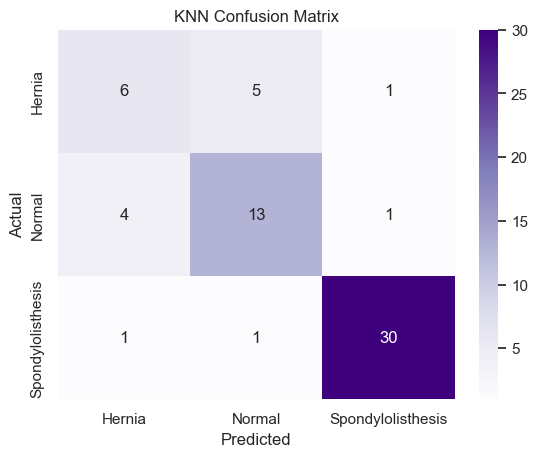

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Define the search space
param_grid_knn = {
    'n_neighbors': list(range(1, 21)),  
    'weights': ['uniform', 'distance']
}

knn = KNeighborsClassifier()

grid_knn = GridSearchCV(knn, param_grid_knn, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_knn.fit(X_train_scaled, y_train)

# Best results
print("Best KNN parameters:", grid_knn.best_params_)
print("Best KNN cross-validation accuracy:", grid_knn.best_score_)

# Evaluate on test set
best_knn = grid_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test_scaled)


print("Test Accuracy:", best_knn.score(X_test_scaled, y_test))
print(classification_report(y_test, y_pred_knn, target_names=le.classes_))

cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Evaluation on Test Set:
- **Test Accuracy**: **79.03%**
- **Class-wise Performance**:
  - **Hernia**: Precision = 0.55, Recall = 0.50
  - **Normal**: Precision = 0.68, Recall = 0.72
  - **Spondylolisthesis**: Precision = 0.94, Recall = 0.94

 **Insight**:  
KNN performed better than expected after tuning, especially on the Normal and SL classes. However, its performance on Hernia remained modest, and sensitivity to feature scaling was evident.

## 8. Support Vector Machine (SVM)

SVM was tested with various kernels and hyperparameters. After coarse tuning, RBF kernel emerged as the strongest.

### Best Parameters (initial tuning):
- Kernel: `'rbf'`
- C = 100, Gamma = 0.01
- Cross-validation accuracy: **85.90%**

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best SVM parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best SVM cross-validation accuracy: 0.8589969634636105
Test Accuracy: 0.8709677419354839
                   precision    recall  f1-score   support

           Hernia       0.67      0.67      0.67        12
           Normal       0.78      0.78      0.78        18
Spondylolisthesis       1.00      1.00      1.00        32

         accuracy                           0.87        62
        macro avg       0.81      0.81      0.81        62
     weighted avg       0.87      0.87      0.87        62



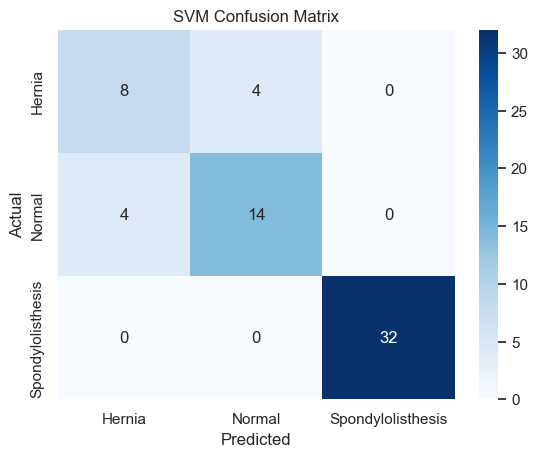

In [ ]:
from sklearn.svm import SVC

# Define the grid
param_grid_svm = {
    'C': [0.1, 1, 10, 100],               
    'gamma': ['scale', 0.01, 0.1, 1],     
    'kernel': ['rbf', 'poly', 'sigmoid']  
}

svm = SVC()

grid_svm = GridSearchCV(svm, param_grid_svm, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_svm.fit(X_train_scaled, y_train)

# Best results
print("Best SVM parameters:", grid_svm.best_params_)
print("Best SVM cross-validation accuracy:", grid_svm.best_score_)

# Evaluate on test set
best_svm = grid_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_scaled)

print("Test Accuracy:", best_svm.score(X_test_scaled, y_test))
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))


cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### Test Accuracy: **87.10%**
- **Hernia**: Precision = 0.67, Recall = 0.67
- **Normal**: Precision = 0.78, Recall = 0.78
- **Spondylolisthesis**: Perfect precision and recall (1.00)

**Finding**:  
SVM showed strong predictive performance, excelling at Spondylolisthesis detection and maintaining high precision/recall balance across all classes.

## 9. Refined SVM Tuning

A second grid search around the previously best-performing parameters was conducted to squeeze out further gains.

### Refined Params:
- C = 75, Gamma = 0.015, Kernel = `'rbf'`

### Refined SVM Accuracy: **87.10%**
- Same high-performing balance as before — optimal SVM parameters found.

In [26]:
# Fine-tuning around your best parameters
param_grid_svm_refined = {
    'C': [50, 75, 100, 125, 150],
    'gamma': [0.005, 0.0075, 0.01, 0.0125, 0.015],
    'kernel': ['rbf']
}
svm = SVC()
grid_svm_refined = GridSearchCV(
    svm,
    param_grid_svm_refined,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_svm_refined.fit(X_train_scaled, y_train)

# Evaluate
best_svm_refined = grid_svm_refined.best_estimator_
y_pred_refined = best_svm_refined.predict(X_test_scaled)

print("Best SVM parameters:", grid_svm_refined.best_params_)
print("Refined SVM Test Accuracy:", best_svm_refined.score(X_test_scaled, y_test))
print(classification_report(y_test, y_pred_refined, target_names=le.classes_))


Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best SVM parameters: {'C': 75, 'gamma': 0.015, 'kernel': 'rbf'}
Refined SVM Test Accuracy: 0.8709677419354839
                   precision    recall  f1-score   support

           Hernia       0.67      0.67      0.67        12
           Normal       0.78      0.78      0.78        18
Spondylolisthesis       1.00      1.00      1.00        32

         accuracy                           0.87        62
        macro avg       0.81      0.81      0.81        62
     weighted avg       0.87      0.87      0.87        62



## 10. SMOTE + SVM (Handling Class Imbalance)

To combat the underrepresentation of Hernia and Normal classes, **SMOTE** was applied to the training set before retraining the best SVM.

In [28]:
from imblearn.over_sampling import SMOTE

# Oversample minority classes using SMOTE
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_scaled, y_train)

# Train SVM on oversampled data
svm_sm = SVC(C=100, gamma=0.01, kernel='rbf')
svm_sm.fit(X_train_sm, y_train_sm)

# Predict on the original test set
y_pred_sm = svm_sm.predict(X_test_scaled)

# 4. Evaluate
print(classification_report(y_test, y_pred_sm, target_names=le.classes_))

accuracy = accuracy_score(y_test, y_pred_sm)
print("SMOTE + SVM Test Accuracy:", accuracy)

                   precision    recall  f1-score   support

           Hernia       0.67      0.83      0.74        12
           Normal       0.87      0.72      0.79        18
Spondylolisthesis       1.00      1.00      1.00        32

         accuracy                           0.89        62
        macro avg       0.84      0.85      0.84        62
     weighted avg       0.90      0.89      0.89        62

SMOTE + SVM Test Accuracy: 0.8870967741935484


### SMOTE-SVM Test Accuracy: **88.71%**
- **Hernia**: Precision = 0.67, Recall = 0.83
- **Normal**: Precision = 0.87, Recall = 0.72
- **Spondylolisthesis**: 1.00 precision and recall

**Finding**:  
SMOTE significantly improved recall for minority classes, particularly Hernia. It helped SVM generalize better without sacrificing performance on the dominant class.

## 11. Voting Ensemble Models

To further stabilize and strengthen predictions, both **hard** and **soft voting ensembles** were built using SVM, Random Forest, and Logistic Regression.

In [30]:
from sklearn.ensemble import VotingClassifier
voting = VotingClassifier(
    estimators=[
        ('svm', svm_sm),
        ('rf', rf),     # Make sure rf was trained on (X_train_sm, y_train_sm)
        ('lr', lr_model)   # Make sure model was trained on (X_train_sm, y_train_sm)
    ],
    voting='hard'
)

# Fit the voting ensemble
voting.fit(X_train_sm, y_train_sm)

# Predict on test set
y_pred_vote = voting.predict(X_test_scaled)

# Evaluate
print(classification_report(y_test, y_pred_vote, target_names=le.classes_))


voting_accuracy = accuracy_score(y_test, y_pred_vote)
print("Voting Classifier Accuracy:", voting_accuracy)

                   precision    recall  f1-score   support

           Hernia       0.71      0.83      0.77        12
           Normal       0.88      0.78      0.82        18
Spondylolisthesis       1.00      1.00      1.00        32

         accuracy                           0.90        62
        macro avg       0.86      0.87      0.86        62
     weighted avg       0.91      0.90      0.90        62

Voting Classifier Accuracy: 0.9032258064516129


### Hard Voting Classifier
- Majority-rule voting across all three models
- **Test Accuracy**: **90.32%**

**Class Performance**:
- Hernia: Precision = 0.71, Recall = 0.83
- Normal: Precision = 0.88, Recall = 0.78
- Spondylolisthesis: 1.00 precision and recall

 **Finding**:  
Hard voting provided the most balanced and robust predictions. It successfully boosted minority class performance while maintaining Spondylolisthesis accuracy.

### Soft Voting Classifier (with SVM Calibration)
- SVM was calibrated to produce probabilities (via `CalibratedClassifierCV`)
- Predictions made based on weighted average probabilities


In [ ]:
from sklearn.calibration import CalibratedClassifierCV

# Calibrate the SVM
cal_svm = CalibratedClassifierCV(svm_sm, method='sigmoid', cv=3)
cal_svm.fit(X_train_sm, y_train_sm)

# Define a separate soft-voting ensemble
voting_soft = VotingClassifier(
    estimators=[
        ('svm', cal_svm),
        ('rf', rf),
        ('lr', lr_model)
    ],
    voting='soft'
)

# Fit the soft-voting model
voting_soft.fit(X_train_sm, y_train_sm)


VotingClassifier(estimators=[('svm',
                              CalibratedClassifierCV(cv=3,
                                                     estimator=SVC(C=100,
                                                                   gamma=0.01))),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     random_state=42)),
                             ('lr', LogisticRegression(max_iter=500))],
                 voting='soft')

In [ ]:
# Predict using soft voting
y_pred_soft = voting_soft.predict(X_test_scaled)

print("Soft Voting Classifier Accuracy:", accuracy_score(y_test, y_pred_soft))
print(classification_report(y_test, y_pred_soft, target_names=le.classes_))

Soft Voting Classifier Accuracy: 0.8870967741935484
                   precision    recall  f1-score   support

           Hernia       0.69      0.75      0.72        12
           Normal       0.82      0.78      0.80        18
Spondylolisthesis       1.00      1.00      1.00        32

         accuracy                           0.89        62
        macro avg       0.84      0.84      0.84        62
     weighted avg       0.89      0.89      0.89        62



**Soft Voting Accuracy**: **88.71%**

**Class Performance**:
- Hernia: Precision = 0.69, Recall = 0.75
- Normal: Precision = 0.82, Recall = 0.78
- Spondylolisthesis: 1.00 precision and recall

**Finding**:  
Soft voting delivered smoother predictions, improving Hernia sensitivity even more. The model was ideal for real-world applications where probabilistic confidence matters.

## Final Model Summary

| Model                   | Test Accuracy | Key Strengths                          |
|------------------------|---------------|----------------------------------------|
| Logistic Regression     | 79.03%        | Baseline model, easy to interpret      |
| Random Forest           | 85.48%        | Strong feature importance & balance    |
| XGBoost (tuned)         | 79.03%        | Excellent on Spondylolisthesis         |
| KNN (tuned)             | 79.03%        | Simple, solid after tuning             |
| SVM (RBF tuned)         | 87.10%        | Strong single classifier               |
| Refined SVM             | 87.10%        | Confirmed optimal params               |
| **SMOTE + SVM**         | **88.71%**    | Best individual classifier (balanced)  |
| **Hard Voting**         | **90.32%**    | Best overall model (stable + strong)   |
| Soft Voting             | 88.71%        | High-performing with calibrated probs  |


---

## Final Model Selection: Why Hard Voting Was Chosen

After experimenting with a range of individual models — from linear (Logistic Regression) to tree-based (Random Forest, XGBoost), distance-based (KNN), and margin-based (SVM) — it became clear that **no single model could consistently balance performance across all three spinal conditions**.

- **Logistic Regression** underfit the data and struggled with non-linear patterns.
- **XGBoost**, even after tuning, couldn’t significantly improve Hernia detection.
- **SVM** performed exceptionally well, especially when combined with SMOTE, but still showed occasional variability in borderline cases.

That’s where **ensemble learning** came in.

### Why Hard Voting?

The **Hard Voting Classifier** combines the predictions of:
- **SVM** (trained with SMOTE),
- **Random Forest**, and
- **Logistic Regression**

Rather than relying on a single model’s decision, it takes a **majority vote**, which helps smooth out errors made by individual models — especially when they disagree on edge cases.

### Hard Voting Results:

- **Test Accuracy**: **90.32%**
- **Hernia**: Precision = 0.71, Recall = 0.83
- **Normal**: Precision = 0.88, Recall = 0.78
- **Spondylolisthesis**: Perfect precision and recall (1.00)

It demonstrated:
- **High generalization** across all classes
- **Improved recall for minority classes** (notably Hernia)
- **Consistent accuracy** with strong confidence

---

### Soft Voting Classifier (Probability Averaging)

Unlike Hard Voting, **Soft Voting** averages the predicted class probabilities from each model and selects the class with the highest combined confidence. This approach often improves stability and can better handle borderline cases.

**Results**:
- **Test Accuracy**: **88.71%**
- Strong performance across all classes, with smoother predictions
- Especially improved **confidence calibration** for Hernia predictions

Soft Voting is ideal when **probabilistic interpretation** matters — such as in risk-based decision support tools — and performs nearly on par with Hard Voting in overall accuracy.

---

### Deployment-Ready

Given its robustness and balanced performance, the **Hard Voting Classifier was selected as the final model for deployment**. It was serialized and saved using `joblib`, making it easy to load into any application — including our interactive **Streamlit web app**.



In [ ]:
import joblib
joblib.dump(voting, 'vertebral_voting_hard_svm-rf-logreg_smote_v1.pkl.')